## Importing Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [2]:
df = pd.read_csv("CO2_dataset.csv")
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [4]:
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("CO2_dataset.csv", parse_dates=['Year'], index_col='Year', date_parser=dateparse) 
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


<AxesSubplot:xlabel='CO2'>

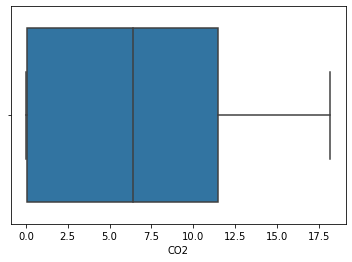

In [5]:
sns.boxplot(df['CO2'])

<AxesSubplot:xlabel='Year'>

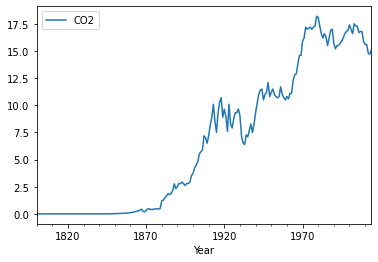

In [6]:
df.plot()

## Transforming data to normal distribution

In [7]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    

### Log Transformation

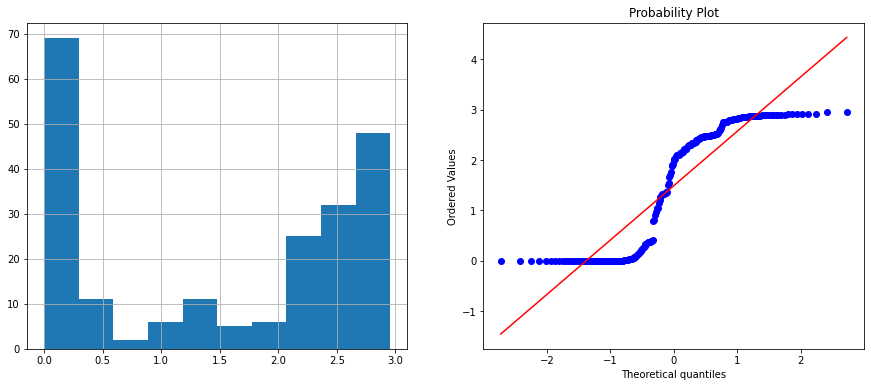

In [8]:
df['Log_co2']=np.log(df['CO2']+1)
diagnostic_plots(df,'Log_co2')

### Reciprocal Transformation

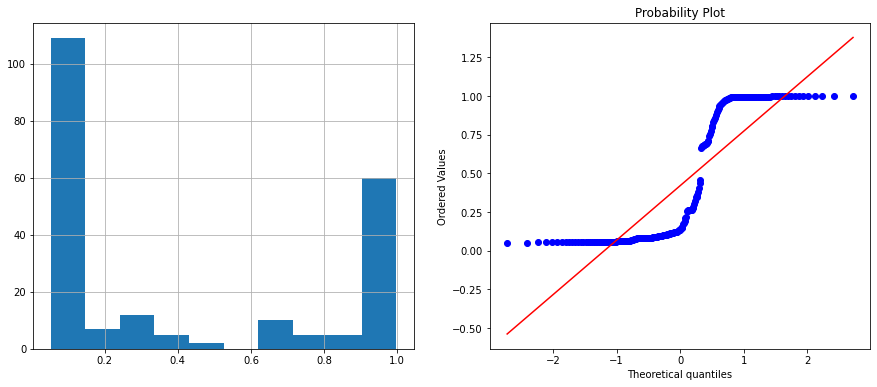

In [9]:
df['Rec_co2']=1/(df['CO2']+1)
diagnostic_plots(df,'Rec_co2')

### Square-Root Transformation

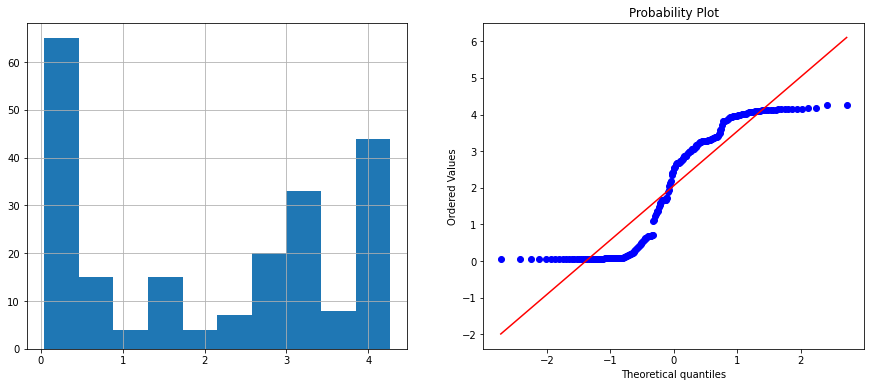

In [10]:
df['sqr_co2']=df['CO2']**(1/2)
diagnostic_plots(df,'sqr_co2')

### Exponential Transformation

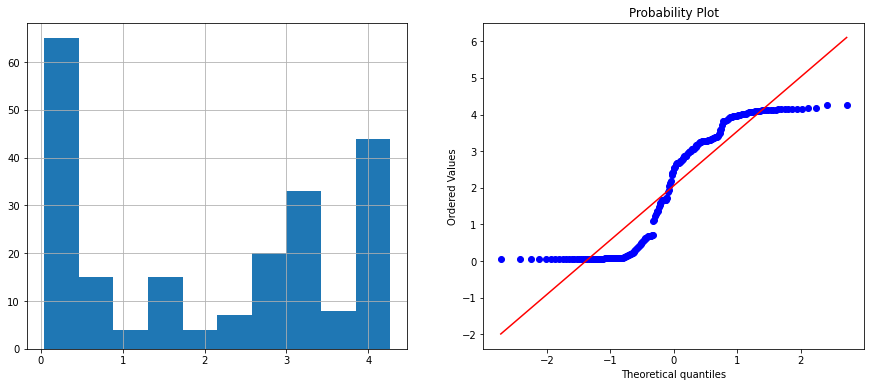

In [11]:
df['Exp_co2']=df['CO2']**(1/5)
diagnostic_plots(df,'sqr_co2')

### Box-cox Transformation

Optimal lambda:  0.1626734565342775


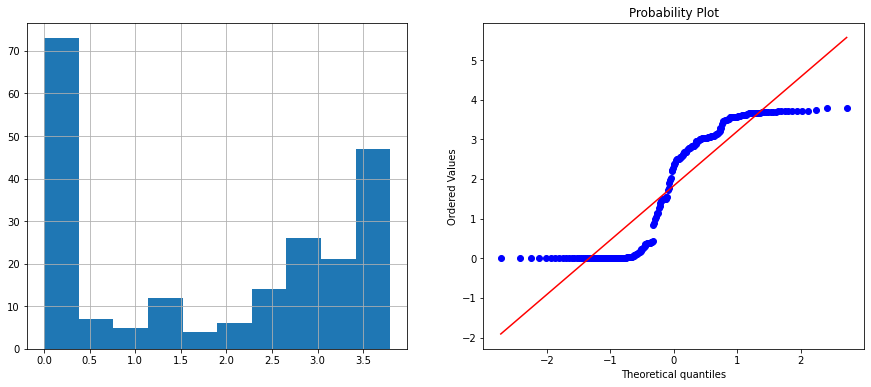

In [12]:
df['co2_boxcox'], param = stats.boxcox(df.CO2+1) # you can vary the exponent as needed

print('Optimal lambda: ', param)

diagnostic_plots(df, 'co2_boxcox')

array([[-1.41804651, -1.48126815,  1.22566669, -1.41804651, -1.41804651,
        -1.4705034 ],
       [-1.41947121, -1.48261311,  1.22571353, -1.41947121, -1.41947121,
        -1.4718637 ],
       [-1.42070347, -1.48377472,  1.22575368, -1.42070347, -1.42070347,
        -1.47303885],
       ...,
       [ 0.99832411,  0.90893134, -1.11259782,  0.99832411,  0.99832411,
         0.92603994],
       [ 0.9939589 ,  0.90676302, -1.10591376,  0.9939589 ,  0.9939589 ,
         0.92349811],
       [ 1.01128301,  0.91533591, -1.13243962,  1.011283  ,  1.01128301,
         0.93355673]])

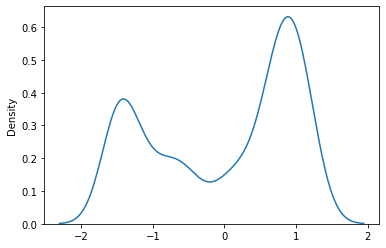

In [13]:

pt = PowerTransformer(method='box-cox')
data = pt.fit_transform(df)
sns.distplot(data, hist=False, kde=True)
data

<AxesSubplot:ylabel='Density'>

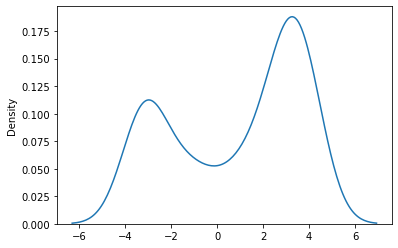

In [14]:

#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(df.CO2) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [15]:
df.dtypes

CO2           float64
Log_co2       float64
Rec_co2       float64
sqr_co2       float64
Exp_co2       float64
co2_boxcox    float64
dtype: object

<AxesSubplot:xlabel='Year'>

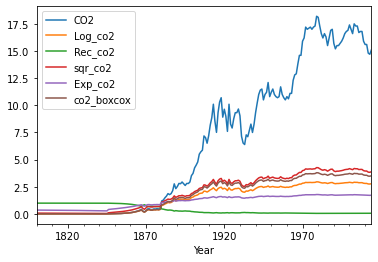

In [16]:
df.plot()

<AxesSubplot:xlabel='Year'>

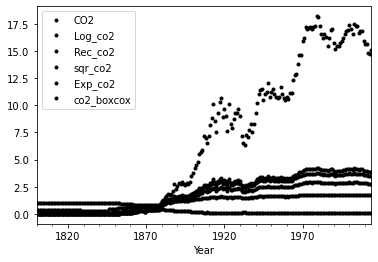

In [17]:
df.plot(style = 'k.')

In [18]:
df.describe()

,CO2,Log_co2,Rec_co2,sqr_co2,Exp_co2,co2_boxcox
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,6.741970,1.490057,0.420248,2.055194,1.159068,1.828802
std,6.522437,1.180641,0.404516,1.590570,0.563587,1.490936
min,0.001750,0.001748,0.052083,0.041833,0.280936,0.001749
25%,0.041050,0.040224,0.080000,0.202429,0.527736,0.040357
50%,6.390000,2.000128,0.135318,2.527845,1.449106,2.363875
75%,11.500000,2.525729,0.960579,3.391165,1.629820,3.123606
max,18.200000,2.954910,0.998253,4.266146,1.786546,3.793997


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'Log_co2'}>],
       [<AxesSubplot:title={'center':'Rec_co2'}>,
        <AxesSubplot:title={'center':'sqr_co2'}>],
       [<AxesSubplot:title={'center':'Exp_co2'}>,
        <AxesSubplot:title={'center':'co2_boxcox'}>]], dtype=object)

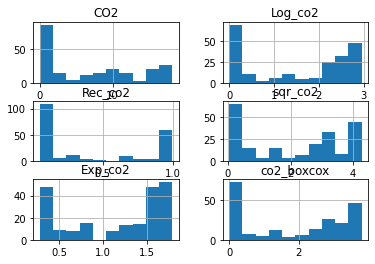

In [19]:
df.hist()

Since we didnot get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution.

#### Dropping all transformed values from dataset

In [20]:
df = df.drop(['co2_boxcox', 'Log_co2','Rec_co2','sqr_co2','Exp_co2'], axis = 1)

In [21]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [22]:
df.dtypes

CO2    float64
dtype: object

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 1800-01-01 to 2014-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     215 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


<AxesSubplot:xlabel='Year'>

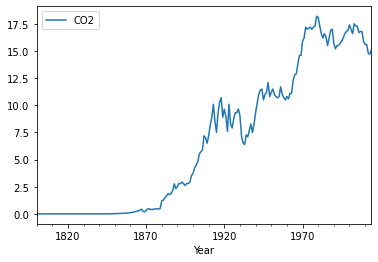

In [24]:
df.plot()

<AxesSubplot:xlabel='Year'>

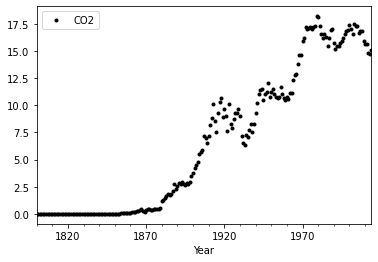

In [25]:
df.plot(style = 'k.')

Preliminary analysis of above plot says that there is presence of clear Level and Trend but we can't say about Seasonality right now.

In [26]:
df.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


array([[<AxesSubplot:title={'center':'CO2'}>]], dtype=object)

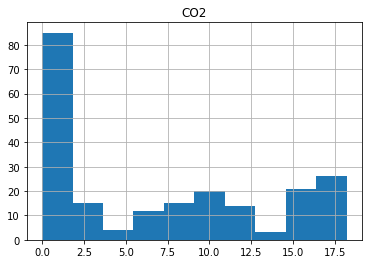

In [27]:
df.hist()

# A) MODEL BUILDING ON STATIONARY DATA

## Test Stationary

Naive test for stationary by checking constant mean and variance

In [28]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.888644, mean2=12.650000
variance1=2.399437, variance2=13.176064


Since mean and variance changes drastically it is evident that out data is not stationary. Let's confirm it using ADFuller test.

### Testing Stationary using ADFuller test

In [29]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 20, center = False).mean()
    rol_std = df.rolling(window = 20, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [30]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

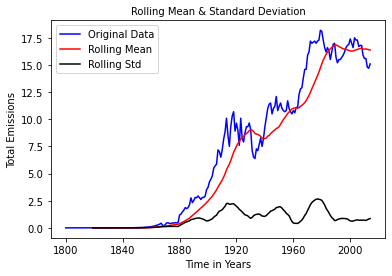

In [31]:
TestStationaryPlot(df)

In [32]:
TestStationaryAdfuller(df)

Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to accept the null hypothesis. Therefore the series is non stationary. 

## Transforming data to Stationary

Transforming data to stationary using three following methods:
- Moving Average
- Differencing
- Decomposing

### 1. Moving Average

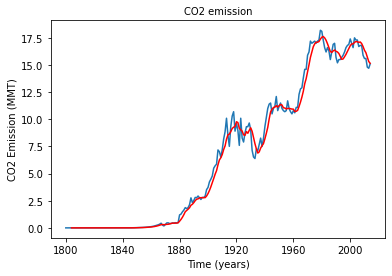

In [33]:
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [34]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(13)

,CO2
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,NaN
1803-01-01,NaN
1804-01-01,-0.000128
1805-01-01,-0.000124
1806-01-01,-0.000130
1807-01-01,-0.000126
1808-01-01,-0.000124


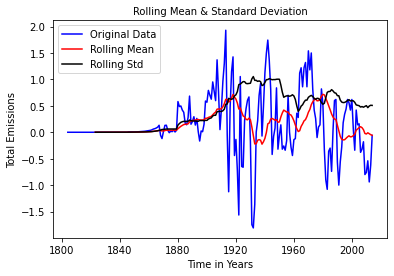

In [35]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [36]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                  -3.944115
p-value                          0.001733
#Lags Used                       4.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
Failed to reject null hypothesis. Data is stationary


The rolling mean values appear to be varying slightly. The Test Statistic is smaller than the 10% 5%, and 1% of critical values. So, we can say with 99% confidence level that the dataset is a stationary series.

### 2. Eliminating trend and seasonality: Differencing

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

#### 2(A) : First order differencing

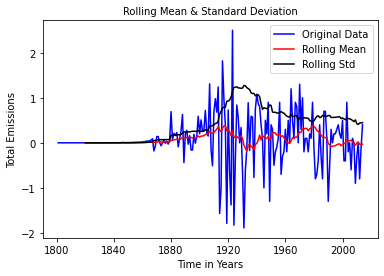

In [37]:
df_first_difference = df - df.shift(1)  
TestStationaryPlot(df_first_difference.dropna(inplace=False))

In [38]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal first order difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

#### 2(B) : Seasonal First order differencing

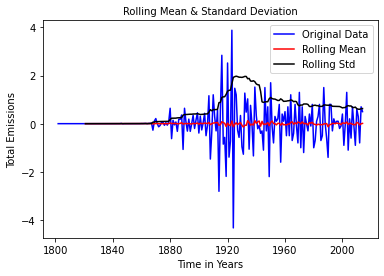

In [39]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))

In [40]:
TestStationaryAdfuller(df_seasonal_first_difference.dropna(inplace=False))

Test Statistic                  -5.536081
p-value                          0.000002
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


We are considering this seasonal first difference for further analysis because it looks more stationary

### 3. Eliminating trend and seasonality: Decomposing

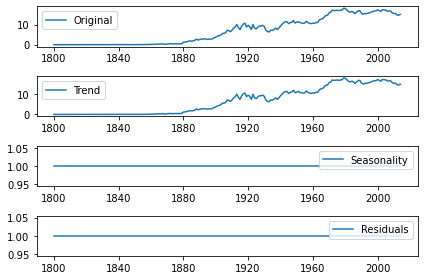

In [41]:
decomposition = seasonal_decompose(df,freq=1,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.

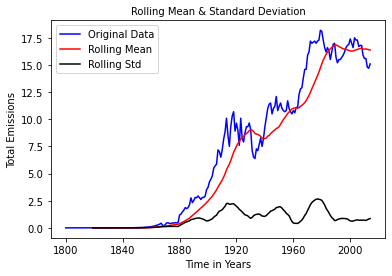

Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


In [42]:
df_decompose = trend
df_decompose.dropna(inplace=True)
TestStationaryPlot(df_decompose)
TestStationaryAdfuller(df_decompose)

## Plot the ACF and PACF charts and find the optimal parameters

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself.
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In the next step we will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation plots.  The plot below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

### ACF & PACF plot for seasonal first order difference

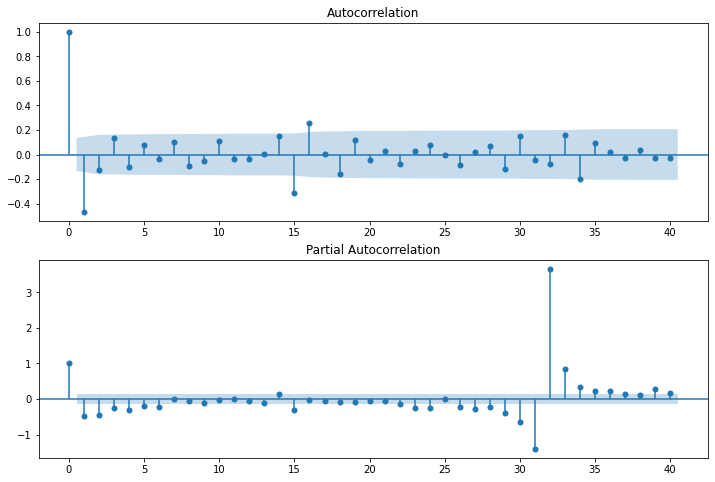

In [43]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax2)

We will find optimal parameters (p,d,q) using grid search later

## Data Partitioning

- **Training Data** = Fit the model only to training period
- **Validating Data** = Assess the model performance on validation
- Deploy model by training on whole dataset
- No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [44]:
#using seasonal first order difference
df_seasonal_first_difference.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,0.00001
1803-01-01,-0.00001
1804-01-01,0.00001


In [45]:
X = df_seasonal_first_difference.dropna(inplace=False)

In [46]:
X.head()

,CO2
Year,
1802-01-01,1.000000e-05
1803-01-01,-1.000000e-05
1804-01-01,1.000000e-05
1805-01-01,-8.673617e-19
1806-01-01,-1.000000e-05


In [47]:
# Create Training and Test
train = X.iloc[:-20]
test = X.iloc[-20:]

In [48]:
print(train.shape,test.shape)

(193, 1) (20, 1)


In [49]:
train.head()

,CO2
Year,
1802-01-01,1.000000e-05
1803-01-01,-1.000000e-05
1804-01-01,1.000000e-05
1805-01-01,-8.673617e-19
1806-01-01,-1.000000e-05


In [50]:
test.head()

,CO2
Year,
1995-01-01,1.776357e-15
1996-01-01,1.000000e-01
1997-01-01,1.000000e-01
1998-01-01,-2.000000e-01
1999-01-01,-1.000000e-01


### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [51]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [52]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [53]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.613
ARIMA(0, 0, 1) RMSE=0.467
ARIMA(0, 0, 2) RMSE=0.471
ARIMA(0, 1, 0) RMSE=1.037
ARIMA(0, 1, 1) RMSE=0.613
ARIMA(0, 1, 2) RMSE=0.450
ARIMA(0, 2, 0) RMSE=1.853
ARIMA(0, 2, 1) RMSE=1.039
ARIMA(0, 2, 2) RMSE=0.679
ARIMA(1, 0, 0) RMSE=0.546
ARIMA(1, 0, 1) RMSE=0.470
ARIMA(1, 0, 2) RMSE=0.464
ARIMA(1, 1, 0) RMSE=0.838
ARIMA(1, 1, 1) RMSE=0.546
ARIMA(1, 1, 2) RMSE=0.451
ARIMA(1, 2, 0) RMSE=1.374
ARIMA(1, 2, 1) RMSE=0.840
ARIMA(1, 2, 2) RMSE=0.613
ARIMA(2, 0, 0) RMSE=0.443
ARIMA(2, 0, 1) RMSE=0.476
ARIMA(2, 0, 2) RMSE=0.462
ARIMA(2, 1, 0) RMSE=0.634
ARIMA(2, 1, 1) RMSE=0.443
ARIMA(2, 1, 2) RMSE=0.455
ARIMA(2, 2, 0) RMSE=0.999
ARIMA(2, 2, 1) RMSE=0.636
ARIMA(2, 2, 2) RMSE=0.446
ARIMA(3, 0, 0) RMSE=0.433
ARIMA(3, 0, 1) RMSE=0.464
ARIMA(3, 0, 2) RMSE=0.467
ARIMA(3, 1, 0) RMSE=0.573
ARIMA(3, 1, 1) RMSE=0.434
ARIMA(3, 1, 2) RMSE=0.444
ARIMA(3, 2, 0) RMSE=0.863
ARIMA(3, 2, 1) RMSE=0.575
ARIMA(3, 2, 2) RMSE=0.438
ARIMA(4, 0, 0) RMSE=0.457
ARIMA(4, 0, 1) RMSE=0.466
ARIMA(4, 0, 

## ARIMA model

In [54]:
#3,0,0
model_arima = ARIMA(train['CO2'],order = (3,0,0))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  193
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -183.744
Date:                Mon, 26 Jul 2021   AIC                            377.488
Time:                        19:02:37   BIC                            393.801
Sample:                    01-01-1802   HQIC                           384.094
                         - 01-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.019      0.027      0.978      -0.036       0.037
ar.L1         -0.7651      0.047    -16.143      0.000      -0.858      -0.672
ar.L2         -0.5819      0.064     -9.086      0.000      -0.707      -0.456
ar.L3         -0.2375      0.049     -4.837      0.000      -0.334      -0.141
sigma2         0.3914      0.021     18.303      0.000       0.349       0.433
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):               284.39
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):           34878.14   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

1995-01-01   -0.167161
1996-01-01    0.084099
1997-01-01   -0.013261
1998-01-01    0.002240
1999-01-01   -0.012652
2000-01-01    0.012848
2001-01-01   -0.001678
2002-01-01   -0.001865
2003-01-01    0.000673
2004-01-01    0.002290
2005-01-01   -0.000379
2006-01-01    0.000119
2007-01-01    0.000907
2008-01-01    0.000648
2009-01-01    0.000269
2010-01-01    0.000523
2011-01-01    0.000611
2012-01-01    0.000486
2013-01-01    0.000470
2014-01-01    0.000534
Freq: AS-JAN, Name: predicted_mean, dtype: float64


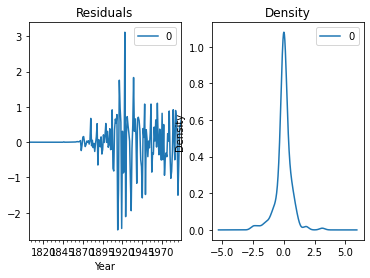

In [56]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [57]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [58]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mape': inf,
 'me': -0.014513993333332914,
 'mae': 0.48264158866205265,
 'mpe': nan,
 'rmse': 0.6130800094481215}

## Auto Regressor (AR) model

In [59]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                  193
Model:                     AutoReg(6)   Log Likelihood                -160.352
Method:               Conditional MLE   S.D. of innovations              0.570
Date:                Mon, 26 Jul 2021   AIC                             -1.037
Time:                        19:02:38   BIC                             -0.899
Sample:                    01-01-1808   HQIC                            -0.981
                         - 01-01-1994                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0034      0.042     -0.081      0.935      -0.085       0.078
CO2.L1        -0.9695      0.071    -13.652      0.000      -1.109      -0.830
CO2.L2        -1.0067      0.095    -10.572      0.0

In [60]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

1995-01-01   -0.355927
1996-01-01   -0.208764
1997-01-01    0.053936
1998-01-01    0.239338
1999-01-01    0.124217
2000-01-01   -0.146736
2001-01-01   -0.040342
2002-01-01   -0.065187
2003-01-01    0.009840
2004-01-01    0.077525
2005-01-01    0.029742
2006-01-01   -0.016715
2007-01-01   -0.048704
2008-01-01   -0.008430
2009-01-01    0.008656
2010-01-01    0.016361
2011-01-01    0.014504
2012-01-01   -0.008896
2013-01-01   -0.013300
2014-01-01   -0.007153
Freq: AS-JAN, dtype: float64


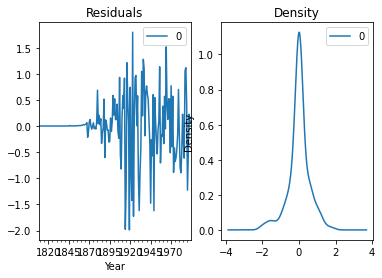

In [61]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [62]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mape': inf,
 'me': -0.027301735949541203,
 'mae': 0.4959715255851231,
 'mpe': nan,
 'rmse': 0.6233294379710825}

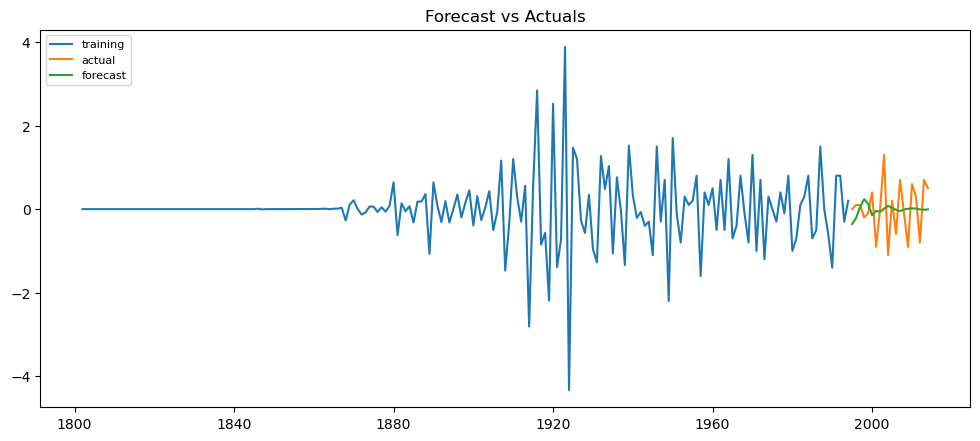

In [63]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Moving Average (MA) model

In [64]:
# only use q or MA parameter
#MA(3)
model_ma = ARIMA(train['CO2'],order = (0,1,3))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  193
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -169.366
Date:                Mon, 26 Jul 2021   AIC                            346.732
Time:                        19:02:39   BIC                            359.762
Sample:                    01-01-1802   HQIC                           352.009
                         - 01-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.0349      0.525     -3.880      0.000      -3.063      -1.007
ma.L2          1.0722      0.539      1.990      0.047       0.016       2.128
ma.L3         -0.0365      0.043     -0.851      0.395      -0.120       0.048
sigma2         0.3141      0.166      1.894      0.058      -0.011       0.639
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               130.46
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):            4546.92   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
pred_ma = model_ma.predict(start=start,end=end)
print(pred_ma)

1995-01-01   -0.066712
1996-01-01   -0.000614
1997-01-01   -0.002694
1998-01-01   -0.002694
1999-01-01   -0.002694
2000-01-01   -0.002694
2001-01-01   -0.002694
2002-01-01   -0.002694
2003-01-01   -0.002694
2004-01-01   -0.002694
2005-01-01   -0.002694
2006-01-01   -0.002694
2007-01-01   -0.002694
2008-01-01   -0.002694
2009-01-01   -0.002694
2010-01-01   -0.002694
2011-01-01   -0.002694
2012-01-01   -0.002694
2013-01-01   -0.002694
2014-01-01   -0.002694
Freq: AS-JAN, Name: predicted_mean, dtype: float64


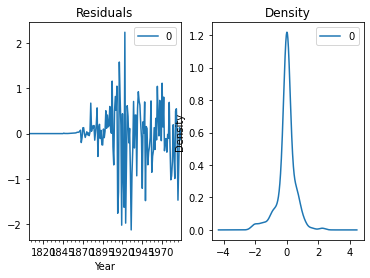

In [66]:
# Plot residual errors
residuals = pd.DataFrame(model_ma.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [67]:
stationary_ma_acc = forecast_accuracy(pred_ma.values, test.values)
stationary_ma_acc

{'mape': inf,
 'me': -0.01579079779331388,
 'mae': 0.4811581595586631,
 'mpe': -inf,
 'rmse': 0.6118373064358483}

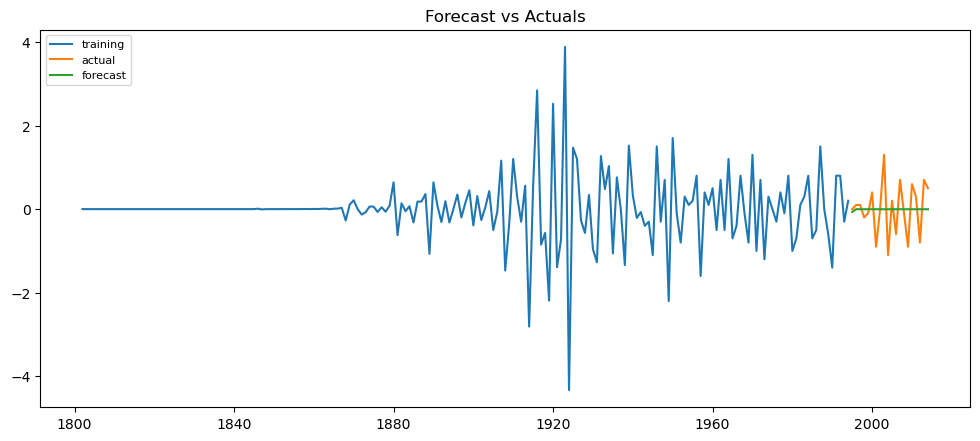

In [68]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ma, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA model

In [69]:
model = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=466.471, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=421.365, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=384.807, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=375.489, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=333.120, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.918 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Obser

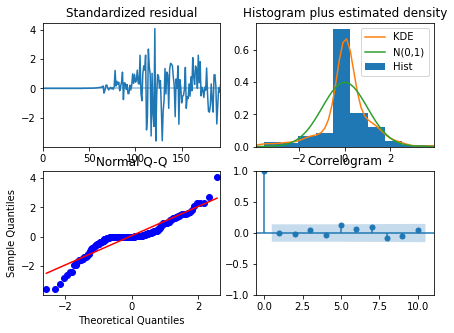

In [70]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [71]:
pred = model.predict(start=start,end=end)
print(pred)

[-1.03647077e-01 -1.78015494e-02  1.26157438e-02  1.42374786e-03
 -1.50034165e-03 -9.05761555e-05  1.74696747e-04  2.00534520e-06
 -1.99364213e-05  7.17376138e-07]


In [72]:
stationary_aa_acc = forecast_accuracy(pred, test.values)
stationary_aa_acc

{'mape': inf,
 'me': -0.020884256934672028,
 'mae': 0.48253413114804333,
 'mpe': nan,
 'rmse': 0.6126499765196677}

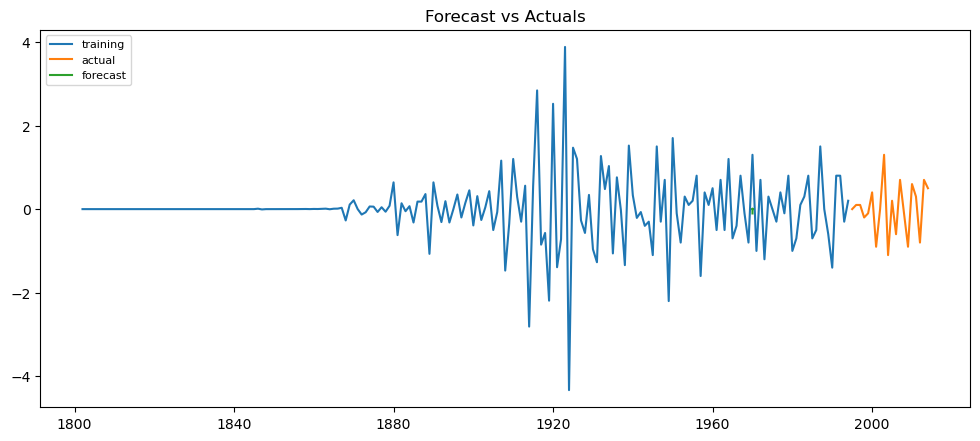

In [73]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [74]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Moving Average","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_ma_acc["rmse"],stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_ma_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_ma_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_ma_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_ma_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
2,Moving Average,0.611837,inf,-0.015791,0.481158,-inf
3,Auto ARIMA,0.612650,inf,-0.020884,0.482534,NaN
0,ARIMA,0.613080,inf,-0.014514,0.482642,NaN
1,Auto Regressor,0.623329,inf,-0.027302,0.495972,NaN


# B) MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA

In [75]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


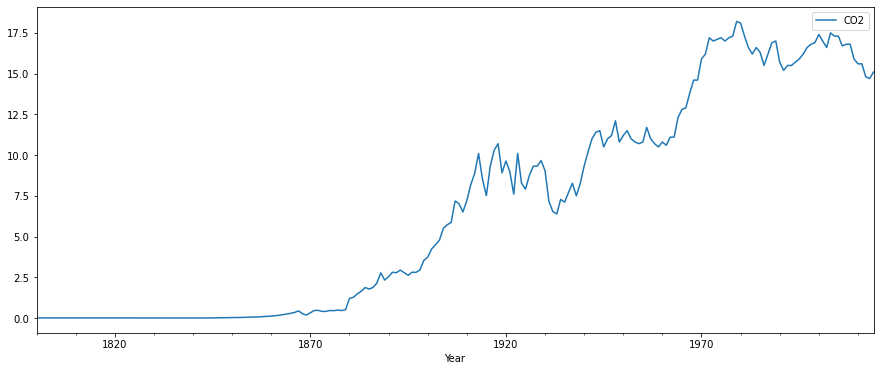

In [76]:
df.plot(figsize=(15, 6))
plt.show()

## Data Partitioning

In [77]:
train = df[:195]
test = df[195:]
print(train.shape,test.shape)

(195, 1) (20, 1)


In [78]:
train.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [79]:
test.head()

,CO2
Year,
1995-01-01,15.9
1996-01-01,16.2
1997-01-01,16.6
1998-01-01,16.8
1999-01-01,16.9


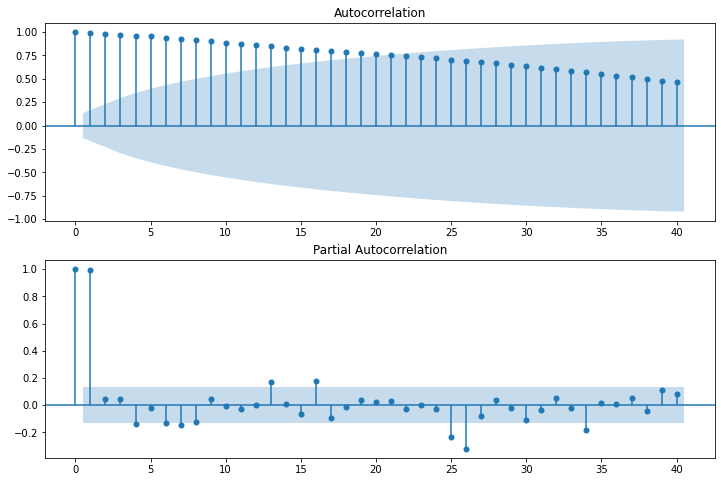

In [80]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

### Hyper-parameter Tuning : Finding out optimal (p,d,q)


In [81]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [82]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [83]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=10.175
ARIMA(0, 0, 1) RMSE=5.218
ARIMA(0, 0, 2) RMSE=3.120
ARIMA(0, 0, 3) RMSE=1.965
ARIMA(0, 0, 4) RMSE=1.886
ARIMA(0, 1, 0) RMSE=0.438
ARIMA(0, 1, 1) RMSE=0.439
ARIMA(0, 1, 2) RMSE=0.439
ARIMA(0, 1, 3) RMSE=0.424
ARIMA(0, 1, 4) RMSE=0.424
ARIMA(0, 2, 0) RMSE=0.612
ARIMA(0, 2, 1) RMSE=0.451
ARIMA(0, 2, 2) RMSE=0.454
ARIMA(0, 2, 3) RMSE=0.458
ARIMA(0, 2, 4) RMSE=0.443
ARIMA(0, 3, 0) RMSE=1.037
ARIMA(0, 3, 1) RMSE=0.613
ARIMA(0, 3, 2) RMSE=0.450
ARIMA(0, 3, 3) RMSE=0.452
ARIMA(0, 3, 4) RMSE=0.461
ARIMA(0, 4, 0) RMSE=1.853
ARIMA(0, 4, 1) RMSE=1.039
ARIMA(0, 4, 2) RMSE=0.679
ARIMA(0, 4, 3) RMSE=0.449
ARIMA(0, 4, 4) RMSE=0.441
ARIMA(1, 0, 0) RMSE=0.437
ARIMA(1, 0, 1) RMSE=0.438
ARIMA(1, 0, 2) RMSE=0.438
ARIMA(1, 0, 3) RMSE=0.423
ARIMA(1, 0, 4) RMSE=0.423
ARIMA(1, 1, 0) RMSE=0.439
ARIMA(1, 1, 1) RMSE=0.433
ARIMA(1, 1, 2) RMSE=0.431
ARIMA(1, 1, 3) RMSE=0.437
ARIMA(1, 1, 4) RMSE=0.440
ARIMA(1, 2, 0) RMSE=0.544
ARIMA(1, 2, 1) RMSE=0.453
ARIMA(1, 2, 2) RMSE=0.446
ARIMA(1, 2,

## ARIMA

In [84]:
model_arima = ARIMA(train['CO2'],order = (3,1,4))
model_arima = model_arima.fit()
model_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  195
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -156.515
Date:                Mon, 26 Jul 2021   AIC                            329.030
Time:                        19:24:41   BIC                            355.173
Sample:                    01-01-1800   HQIC                           339.616
                         - 01-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4731      0.215      6.850      0.000       1.052       1.895
ar.L2         -0.0994      0.411     -0.242      0.809      -0.904       0.705
ar.L3         -0.4473      0.214     -2.093      0.036      -0.866      -0.028
ma.L1         -1.5439      0.224     -6.878      0.000      -1.984      -1.104
ma.L2          0.0565      0.409      0.138      0.890      -0.745       0.858
ma.L3          0.7734      0.208      3.712      0.000       0.365       1.182
ma.L4         -0.2127      0.057     -3.736      0.000      -0.324      -0.101
sigma2         0.2905      0.024     12.140      0.000       0.244       0.337
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                75.75
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):            3473.75   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

1995-01-01    15.890050
1996-01-01    16.091808
1997-01-01    16.339609
1998-01-01    16.587769
1999-01-01    16.838432
2000-01-01    17.072151
2001-01-01    17.280498
2002-01-01    17.452038
2003-01-01    17.579460
2004-01-01    17.656905
2005-01-01    17.681581
2006-01-01    17.653229
2007-01-01    17.574370
2008-01-01    17.449986
2009-01-01    17.287284
2010-01-01    17.095259
2011-01-01    16.884214
2012-01-01    16.665207
2013-01-01    16.449479
2014-01-01    16.247883
Freq: AS-JAN, Name: predicted_mean, dtype: float64


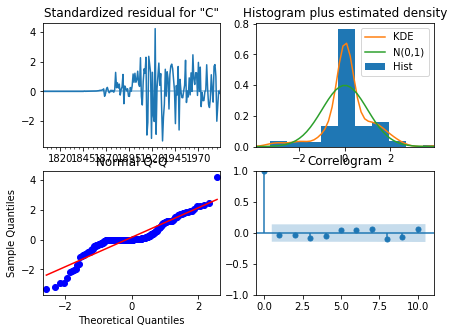

In [86]:
model_arima.plot_diagnostics(figsize=(7,5))
plt.show()

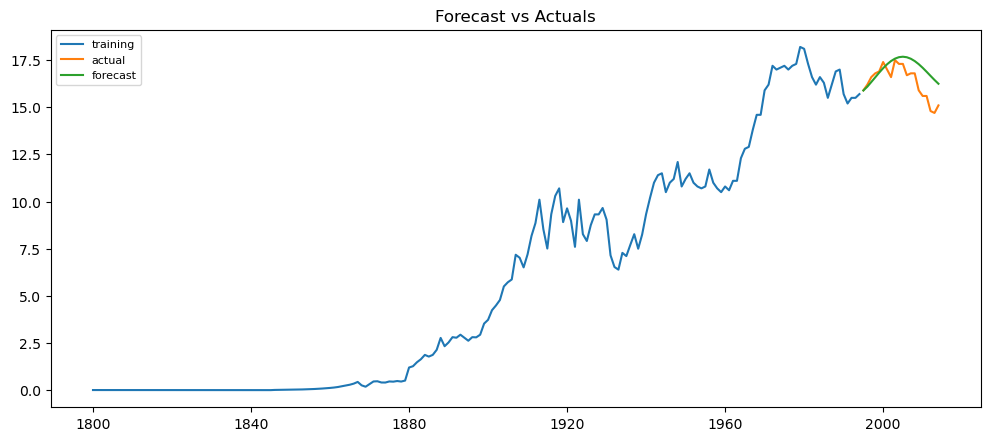

In [87]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [88]:
ns_arima_acc = forecast_accuracy(pred_arima,test.CO2)
ns_arima_acc

{'mape': 0.04507531956046861,
 'me': 0.6138606213472423,
 'mae': 0.7118787030575445,
 'mpe': 0.03926449263752005,
 'rmse': 0.9197152179075153}

## Auto ARIMA

In [89]:
model_auto = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=327.249, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=328.890, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=328.788, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=329.304, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=330.241, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.466 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -161.625
Date:                Mon, 26 Jul 2021   AIC                            327.249
Time:                        19:24:43   BIC                            333.785
Sample:                             0   HQIC                           329.896
                                - 195                                         
Co

In [90]:
pred_auto_arima = model_auto.predict(start=start,end=end)
print(pred_auto_arima)

[15.78089841 15.86179682 15.94269523 16.02359364 16.10449205 16.18539046
 16.26628887 16.34718728 16.42808569 16.50898411]


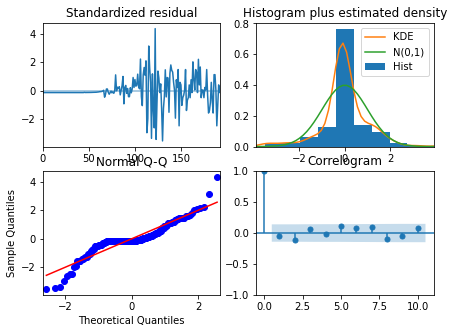

In [91]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

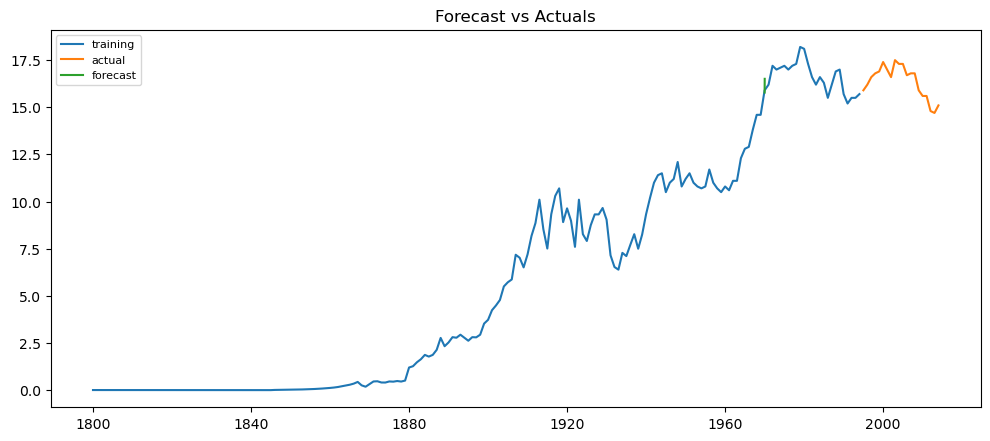

In [92]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_auto_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto Regressor 

In [93]:
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                  195
Model:                     AutoReg(1)   Log Likelihood                -161.622
Method:               Conditional MLE   S.D. of innovations              0.557
Date:                Mon, 26 Jul 2021   AIC                             -1.141
Time:                        19:24:44   BIC                             -1.090
Sample:                    01-01-1801   HQIC                            -1.120
                         - 01-01-1994                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0784      0.055      1.420      0.156      -0.030       0.187
CO2.L1         1.0004      0.007    149.772      0.000       0.987       1.014
                                    Roots           

In [94]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

1995-01-01    15.785295
1996-01-01    15.870628
1997-01-01    15.955998
1998-01-01    16.041406
1999-01-01    16.126852
2000-01-01    16.212335
2001-01-01    16.297856
2002-01-01    16.383414
2003-01-01    16.469010
2004-01-01    16.554643
2005-01-01    16.640314
2006-01-01    16.726023
2007-01-01    16.811770
2008-01-01    16.897554
2009-01-01    16.983376
2010-01-01    17.069236
2011-01-01    17.155133
2012-01-01    17.241069
2013-01-01    17.327042
2014-01-01    17.413052
Freq: AS-JAN, dtype: float64


In [95]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

{'mape': 0.04987211514115063,
 'me': 0.22310031674086298,
 'mae': 0.7960986374051282,
 'mpe': 0.01637588551167463,
 'rmse': 0.9978427121395914}

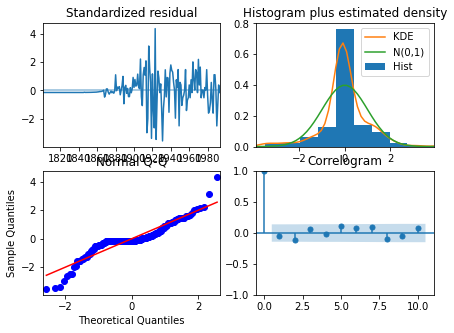

In [96]:
model_ar.plot_diagnostics(figsize=(7,5))
plt.show()

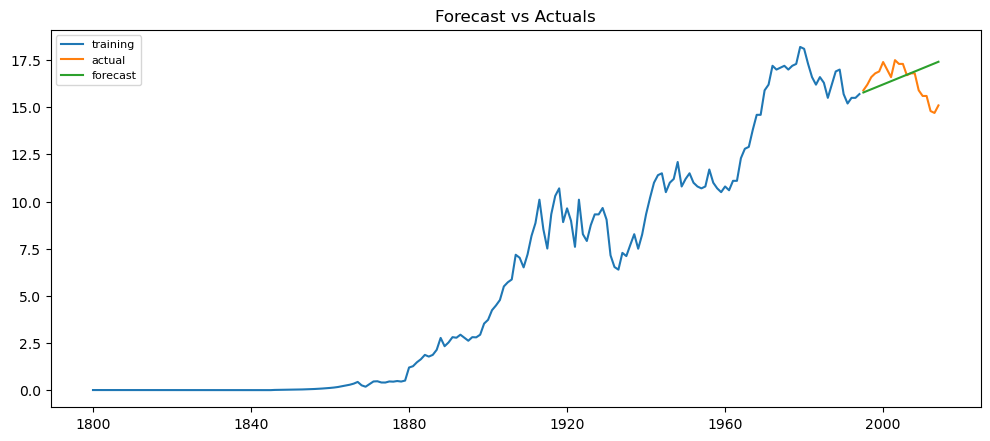

In [97]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Single Exponential Smoothing

In [98]:
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)

Text(0.5, 1.0, 'Fitted values Vs Original Values')

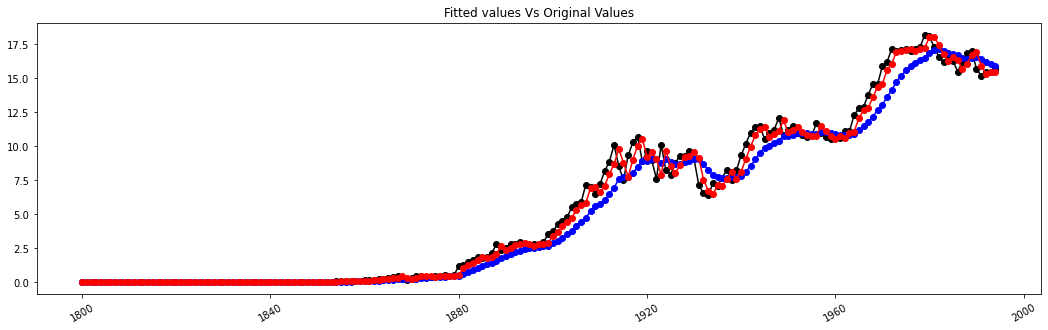

In [99]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [100]:
pred_ses = fit1.predict(start = len(train),end = len(train)+len(test)-1)

In [101]:
ns_ses_acc = forecast_accuracy(pred_ses,test.CO2)
ns_ses_acc

{'mape': 0.05140341313825274,
 'me': -0.48532979923801467,
 'mae': 0.8501648996190075,
 'mpe': -0.027004457582465242,
 'rmse': 0.9682045310926879}

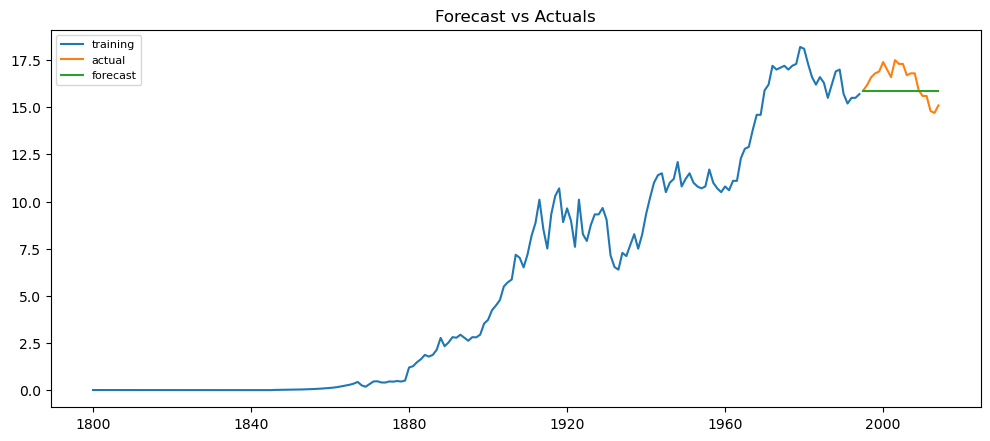

In [102]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Double Exponential Smoothing or Holt's method

In [103]:
#fit1 = Holt(train1).fit()
fit3 = Holt(train,exponential=True,damped_trend=False).fit()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

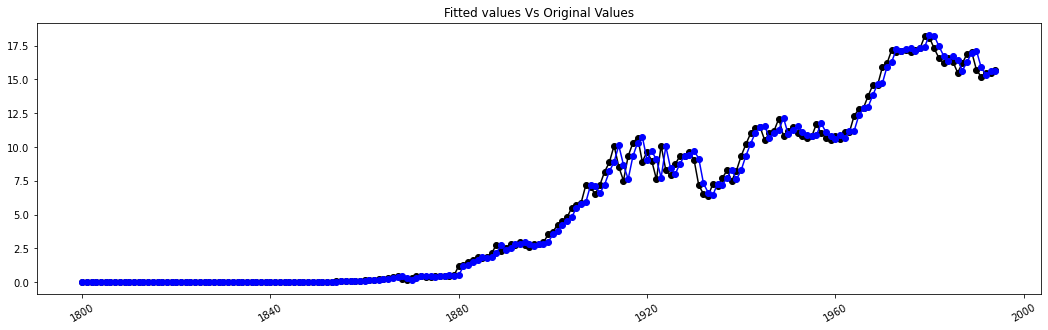

In [104]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
#plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [105]:
pred_holt = fit3.predict(start = len(train),end = len(train)+len(test)-1)

In [106]:
ns_des_acc = forecast_accuracy(pred_holt,test.CO2)
ns_des_acc

{'mape': 0.06935411673149652,
 'me': 0.5653153141412538,
 'mae': 1.0870913807527978,
 'mpe': 0.0387373113043582,
 'rmse': 1.4907758268269147}

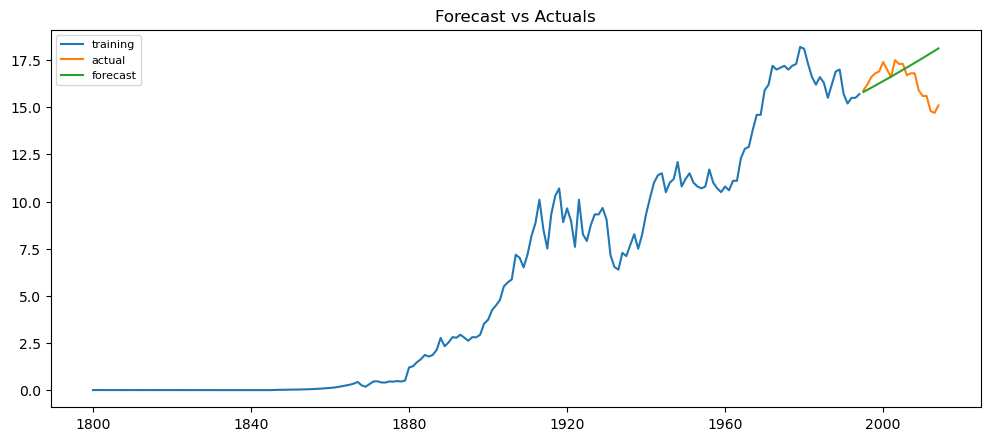

In [107]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Triple Exponential Smoothing or Holt - Winter's Method

**seasonality = additive** , **Trend = additive**

In [108]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["CO2"],seasonal="add",trend="add",seasonal_periods=2,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = start,end = end)

In [109]:
ns_tes_add_add_acc = forecast_accuracy(pred_hwe_add_add,test.CO2)
ns_tes_add_add_acc

{'mape': 0.057021469104862235,
 'me': -0.3115317002807786,
 'mae': 0.9298780763401264,
 'mpe': -0.015958078212692173,
 'rmse': 1.022880670636448}

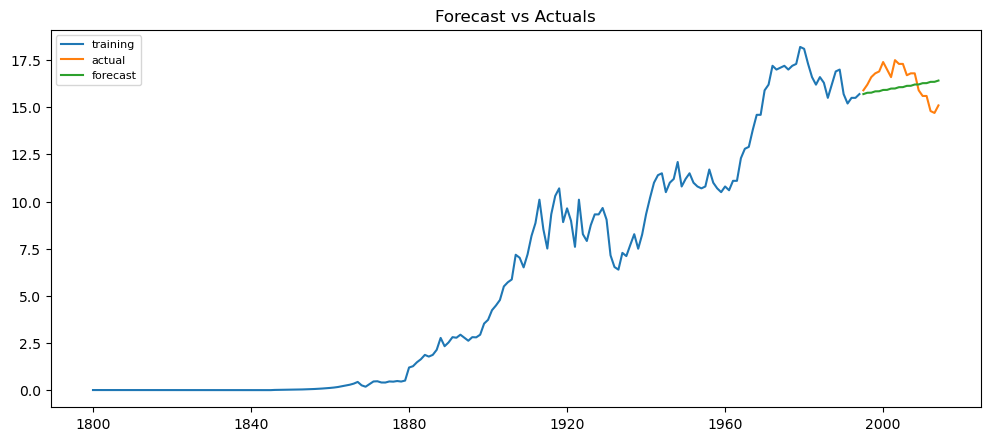

In [110]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative** , **Trend = additive**

In [111]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="add",seasonal_periods=2).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = start,end = end)

In [112]:
ns_tes_mul_add_acc = forecast_accuracy(pred_hwe_mul_add,test.CO2)
ns_tes_mul_add_acc

{'mape': 0.059083756098307204,
 'me': 0.10146834423323199,
 'mae': 0.9407653616006421,
 'mpe': 0.009813626419986727,
 'rmse': 1.167760869730275}

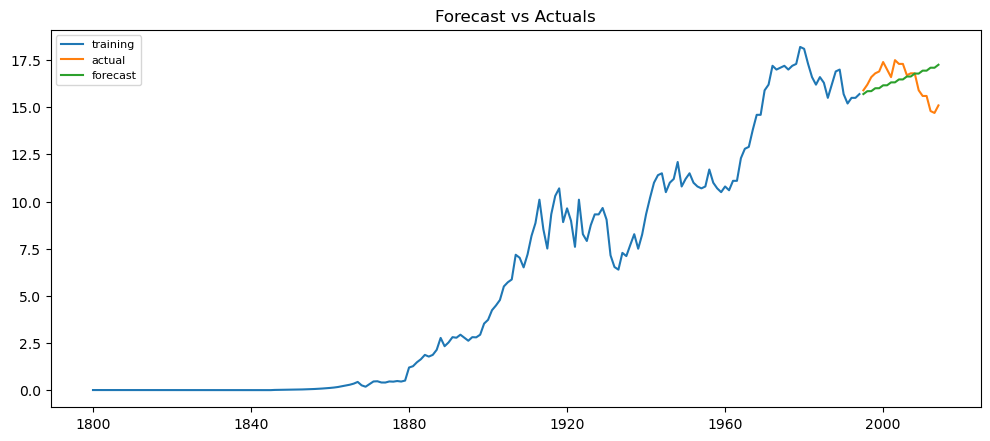

In [113]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**seasonality = multiplicative , Trend = multiplicative**

In [114]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_mul = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="mul",seasonal_periods=2).fit()
pred_hwe_mul_mul = hwe_model_mul_add.predict(start = start,end = end)

In [115]:
ns_tes_mul_mul_acc = forecast_accuracy(pred_hwe_mul_mul,test.CO2)
ns_tes_mul_mul_acc

{'mape': 0.059083756098307204,
 'me': 0.10146834423323199,
 'mae': 0.9407653616006421,
 'mpe': 0.009813626419986727,
 'rmse': 1.167760869730275}

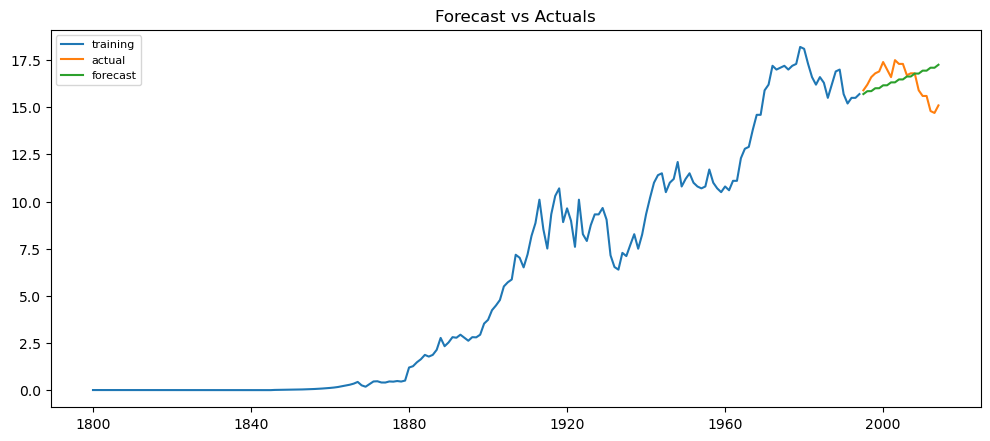

In [116]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_mul, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## LSTM using RNN

In [117]:
scaler = MinMaxScaler()

In [118]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [119]:
scaled_train[:10]

array([[0.00021595],
       [0.00021211],
       [0.00020881],
       [0.00020496],
       [0.00020167],
       [0.00019837],
       [0.00019452],
       [0.00019123],
       [0.00018793],
       [0.00018463]])

In [120]:
#define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [121]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.00021595 0.00021211 0.00020881 0.00020496 0.00020167]
predict this y: 
 [[0.00019837]]


In [122]:
X.shape

(1, 5, 1)

In [123]:
#define model
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [124]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 60)             14880     
_________________________________________________________________
dropout (Dropout)            (None, 5, 60)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                2

In [125]:
#fit model
model.fit(generator,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
190/190 [==============================] - 35s 9ms/step - loss: 0.1031
Epoch 2/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0083
Epoch 3/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0093
Epoch 4/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0095
Epoch 5/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0099
Epoch 6/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0061
Epoch 7/50
190/190 [==============================] - 2s 8ms/step - loss: 0.0074
Epoch 8/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0099
Epoch 9/50
190/190 [==============================] - 2s 8ms/step - loss: 0.0099
Epoch 10/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0042
Epoch 11/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0083
Epoch 12/50
190/190 [==============================] - 2s 9ms/step - loss: 0.0062
Epoch 13/50
190/190 [===

Text(0.5, 1.0, 'Loss per Epochs')

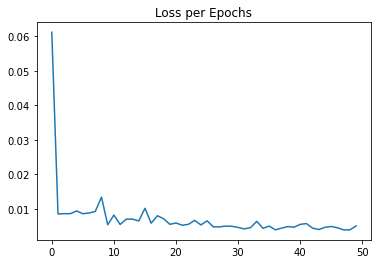

In [126]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [127]:
last_train_batch = scaled_train[-5:]

In [128]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [129]:
model.predict(last_train_batch)

array([[0.8870563]], dtype=float32)

In [130]:
scaled_test[0]

array([0.87361422])

In [131]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

In [132]:
test_predictions

[array([0.8870563], dtype=float32),
 array([0.8859398], dtype=float32),
 array([0.8913216], dtype=float32),
 array([0.8952456], dtype=float32),
 array([0.9002732], dtype=float32),
 array([0.9042406], dtype=float32),
 array([0.9052414], dtype=float32),
 array([0.9068951], dtype=float32),
 array([0.9082509], dtype=float32),
 array([0.909419], dtype=float32),
 array([0.9101711], dtype=float32),
 array([0.91058403], dtype=float32),
 array([0.91101325], dtype=float32),
 array([0.9113484], dtype=float32),
 array([0.91159856], dtype=float32),
 array([0.9117639], dtype=float32),
 array([0.9118813], dtype=float32),
 array([0.9119835], dtype=float32),
 array([0.9120599], dtype=float32),
 array([0.91211504], dtype=float32)]

In [133]:
test.head()

,CO2
Year,
1995-01-01,15.9
1996-01-01,16.2
1997-01-01,16.6
1998-01-01,16.8
1999-01-01,16.9


In [134]:
true_predictions = scaler.inverse_transform(test_predictions)

In [135]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Year'>

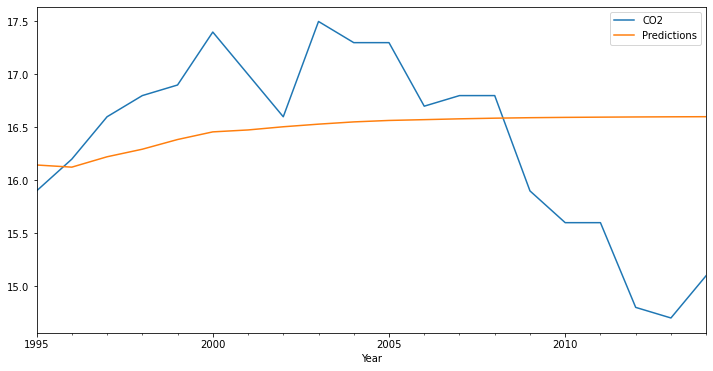

In [136]:
test.plot(figsize=(12,6))

In [137]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.CO2)
ns_lstm_acc

{'mape': 0.04449170265810076,
 'me': 0.10381178124248817,
 'mae': 0.7086949930638077,
 'mpe': 0.009166039370191812,
 'rmse': 0.8833397963583586}

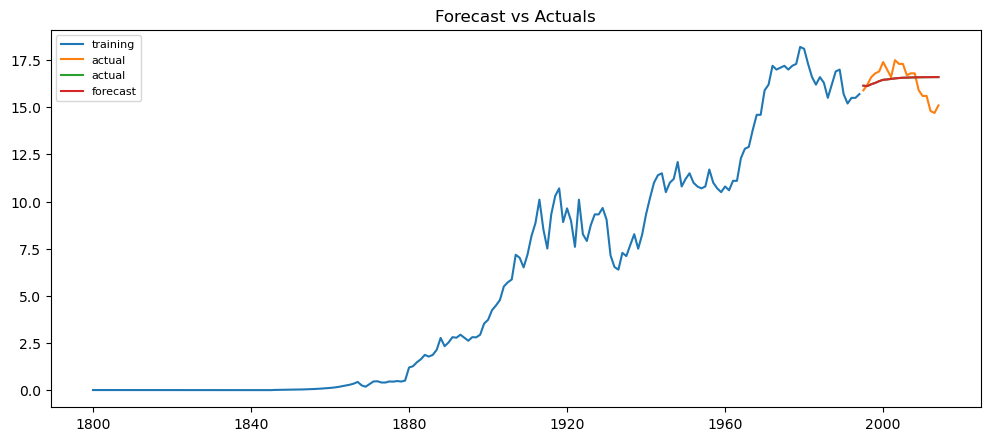

In [138]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecasting Accuracy

In [139]:
data = {"MODEL":pd.Series(["ARIMA(3,1,4)","Auto Regressor","single exponential smoothing","Double exponential smoothing","Triple exponential smoothing(additive seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & multiplicative trend)","LSTM(RNN)"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_ar_acc["rmse"],ns_ses_acc["rmse"],ns_des_acc["rmse"],ns_tes_add_add_acc["rmse"],ns_tes_mul_add_acc["rmse"],ns_tes_mul_mul_acc["rmse"],ns_lstm_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_ar_acc["mape"],ns_ses_acc["mape"],ns_des_acc["mape"],ns_tes_add_add_acc["mape"],ns_tes_mul_add_acc["mape"],ns_tes_mul_mul_acc["mape"],ns_lstm_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_ar_acc["me"],ns_ses_acc["me"],ns_des_acc["me"],ns_tes_add_add_acc["me"],ns_tes_mul_add_acc["me"],ns_tes_mul_mul_acc["me"],ns_lstm_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_ar_acc["mae"],ns_ses_acc["mae"],ns_des_acc["mae"],ns_tes_add_add_acc["mae"],ns_tes_mul_add_acc["mae"],ns_tes_mul_mul_acc["mae"],ns_lstm_acc["mae"]]),
"MPE_values":pd.Series([ns_arima_acc["mpe"],ns_ar_acc["mpe"],ns_ses_acc["mpe"],ns_des_acc["mpe"],ns_tes_add_add_acc["mpe"],ns_tes_mul_add_acc["mpe"],ns_tes_mul_mul_acc["mpe"],ns_lstm_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values,MPE_values
7,LSTM(RNN),0.883340,0.044492,0.103812,0.708695,0.009166
0,"ARIMA(3,1,4)",0.919715,0.045075,0.613861,0.711879,0.039264
1,Auto Regressor,0.997843,0.049872,0.223100,0.796099,0.016376
2,single exponential smoothing,0.968205,0.051403,-0.485330,0.850165,-0.027004
4,Triple exponential smoothing(additive seasonal...,1.022881,0.057021,-0.311532,0.929878,-0.015958
5,Triple exponential smoothing(multiplicative se...,1.167761,0.059084,0.101468,0.940765,0.009814
6,Triple exponential smoothing(multiplicative se...,1.167761,0.059084,0.101468,0.940765,0.009814
3,Double exponential smoothing,1.490776,0.069354,0.565315,1.087091,0.038737


# Final Model

We have selected **ARIMA(3,1,4)** as our final model beacuse of following reasons:
- least MAPE & MAE value
- Forecasted values vs Actual values graphs capturing more information when compared to other models

In [140]:
final_arima = ARIMA(df['CO2'],order = (3,1,4))
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  215
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -166.981
Date:                Mon, 26 Jul 2021   AIC                            349.962
Time:                        19:26:58   BIC                            376.889
Sample:                    01-01-1800   HQIC                           360.843
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4767      0.189      7.809      0.000       1.106       1.847
ar.L2         -0.1037      0.363     -0.286      0.775      -0.814       0.607
ar.L3         -0.4480      0.188     -2.379      0.017      -0.817      -0.079
ma.L1         -1.5604      0.196     -7.958      0.000      -1.945      -1.176
ma.L2          0.0684      0.360      0.190      0.849      -0.638       0.775
ma.L3          0.7974      0.186      4.283      0.000       0.432       1.162
ma.L4         -0.2329      0.052     -4.502      0.000      -0.334      -0.131
sigma2         0.2757      0.021     13.169      0.000       0.235       0.317
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                77.79
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             231.64   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [141]:
final_arima.fittedvalues.tail()

Year
2010-01-01    15.748355
2011-01-01    15.433405
2012-01-01    15.301891
2013-01-01    14.560173
2014-01-01    14.550239
dtype: float64

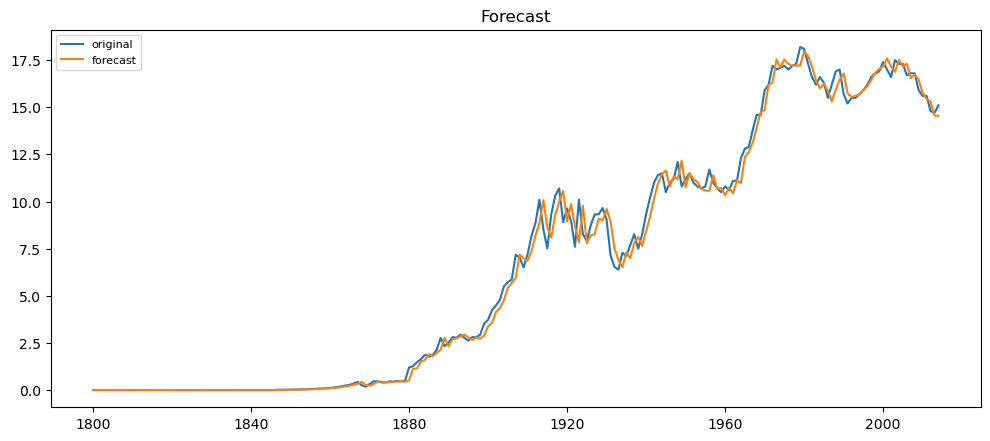

In [142]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### creating dataframe for future forecasting

In [143]:
future_dates=[df.index[-1]+ DateOffset(years=x)for x in range(0,6)]

In [144]:
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [145]:
future_df.tail()

,CO2
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN


In [146]:
len(future_df)

5

### Forecasting for  next 5 years using Final ARIMA model

In [147]:
future_df['CO2'] = final_arima.predict(start = 215, end = 220, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years')

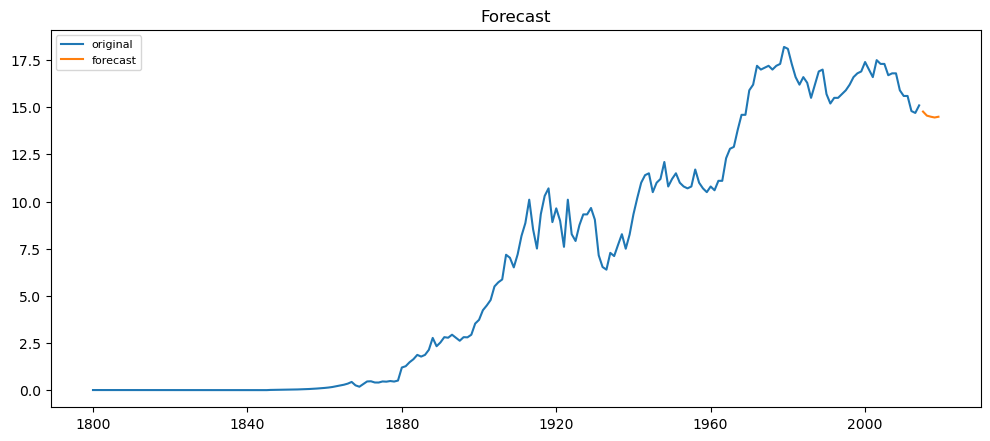

In [148]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [149]:
df.tail()

,CO2
Year,
2010-01-01,15.6
2011-01-01,15.6
2012-01-01,14.8
2013-01-01,14.7
2014-01-01,15.1


In [150]:
future_df.tail()

,CO2
2015-01-01,14.772273
2016-01-01,14.557527
2017-01-01,14.500982
2018-01-01,14.458574
2019-01-01,14.498019


In [151]:
# Exporting to csv file
future_df.to_csv(r'forecast_data_5years.csv',index=True)

## Forecast for 10 years

In [152]:
future_dates_10=[df.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10.tail()
len(future_df_10)

10

In [153]:
future_df_10['CO2'] = final_arima.predict(start = 215, end = 225, dynamic= True) 

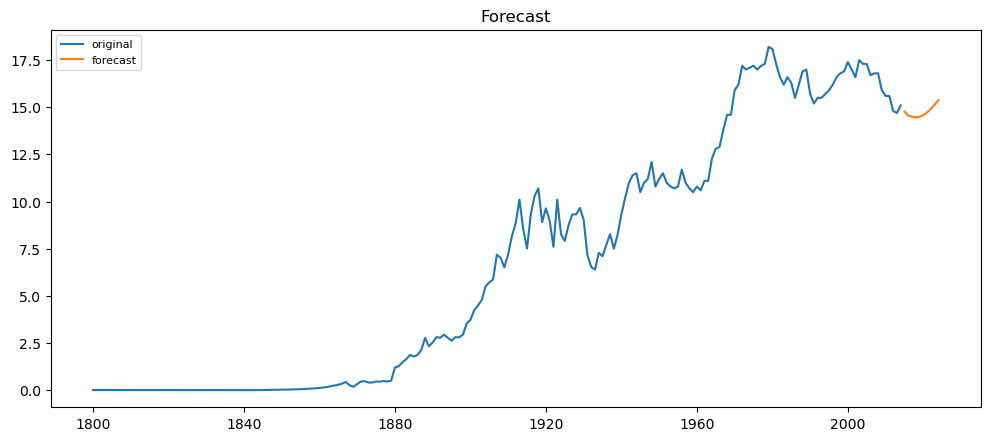

In [154]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [155]:
future_df_10

,CO2
2015-01-01,14.772273
2016-01-01,14.557527
2017-01-01,14.500982
2018-01-01,14.458574
2019-01-01,14.498019
2020-01-01,14.585996
2021-01-01,14.730815
2022-01-01,14.917866
2023-01-01,15.139643
2024-01-01,15.382854


In [156]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_10years.csv',index=True)

In [157]:
# Saving the pickle file
import pickle
pickle.dump(final_arima, open('Forecast_arima.pkl','wb'))